<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = False
CROPPING = False
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029321_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029322_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029323_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029324_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029325_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029326_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029327_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029328_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029329_segmentation.png  
  in

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [4]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [5]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        if CROPPING:
          image = image[y_min:y_max, x_min:x_max]

        # print(cropped_image.shape)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [6]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [7]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  return train_data, validation_data,test_data


In [8]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

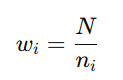

In [9]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [10]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [11]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [12]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [13]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [14]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [15]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            if isinstance(output, tuple) or hasattr(output, 'logits'):
                output = output.logits

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [16]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [17]:
from itertools import product
BINARY = False #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
img_sizes = {'alexnet': 224,'resnet152':224,'inceptionv3':299,'efficientnetb1':224,'alexnetmulticlass':224,'resnet152multiclass':224,'inceptionv3multiclass':299,'efficientnetb1multiclass':224}

nom_model = 'alexnet'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = img_sizes[nom_model]


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None

if SEGMENTATION == False:
  transform = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.Resize((SIZE,SIZE)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std)
  ])

  transform_training = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=20),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean, std=std),
  ])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)


parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "SEGMENTATION": SEGMENTATION,
                "CROPPING": CROPPING,
                "img_size": SIZE,
                "random_state": 42,
                "WeightsAndBiases": wandb.run.get_url(),
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

2.845929572315279


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 129MB/s]


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': 2.845929572315279, 'CLAHE': False}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.6731113968379944
Accuracy train epoch: 1  train_acc: 0.7726819992756248
F1 train epoch: 1  train_f1: 0.7803231705181594
Recall train epoch: 1  train_recall: 0.7726819992756248


Pèrdua validació epoch: 1  val_loss: 0.5727844694629312
Accuracy val epoch: 1  val_acc: 0.8322265625
F1 val epoch: 1  val_f1: 0.8379606540483611
Recall val epoch: 1  val_recall: 0.8322265625
Recall val epoch: 1  val_precision: 0.8543702614204056


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5567840540789039
Accuracy train epoch: 2  train_acc: 0.8168915248098515
F1 train epoch: 2  train_f1: 0.8293839707489666
Recall train epoch: 2  train_recall: 0.8168915248098515


Pèrdua validació epoch: 2  val_loss: 0.5428355587646365
Accuracy val epoch: 2  val_acc: 0.827734375
F1 val epoch: 2  val_f1: 0.8356137840187068
Recall val epoch: 2  val_recall: 0.827734375
Recall val epoch: 2  val_precision: 0.8583876310410093


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.5301888239573672
Accuracy train epoch: 3  train_acc: 0.8331899674031148
F1 train epoch: 3  train_f1: 0.8436546827690116
Recall train epoch: 3  train_recall: 0.8331899674031148


Pèrdua validació epoch: 3  val_loss: 0.4985324116423726
Accuracy val epoch: 3  val_acc: 0.8326171875
F1 val epoch: 3  val_f1: 0.8441002806503153
Recall val epoch: 3  val_recall: 0.8326171875
Recall val epoch: 3  val_precision: 0.8704928697683026


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.5025709402335592
Accuracy train epoch: 4  train_acc: 0.8403997645780514
F1 train epoch: 4  train_f1: 0.8497068221449992
Recall train epoch: 4  train_recall: 0.8403997645780514


Pèrdua validació epoch: 4  val_loss: 0.5141237294301391
Accuracy val epoch: 4  val_acc: 0.8099609375
F1 val epoch: 4  val_f1: 0.8249108776819615
Recall val epoch: 4  val_recall: 0.8099609375
Recall val epoch: 4  val_precision: 0.8683190191093866


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.49110113339595113
Accuracy train epoch: 5  train_acc: 0.8468625498007968
F1 train epoch: 5  train_f1: 0.8570393974140779
Recall train epoch: 5  train_recall: 0.8468625498007968


Pèrdua validació epoch: 5  val_loss: 0.4955767369829118
Accuracy val epoch: 5  val_acc: 0.8505859375
F1 val epoch: 5  val_f1: 0.8576616799181431
Recall val epoch: 5  val_recall: 0.8505859375
Recall val epoch: 5  val_precision: 0.8722903030241216


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.47208221099409925
Accuracy train epoch: 6  train_acc: 0.852476457805143
F1 train epoch: 6  train_f1: 0.8617593682255129
Recall train epoch: 6  train_recall: 0.852476457805143


Pèrdua validació epoch: 6  val_loss: 0.4816930713132024
Accuracy val epoch: 6  val_acc: 0.86875
F1 val epoch: 6  val_f1: 0.8720817765247543
Recall val epoch: 6  val_recall: 0.86875
Recall val epoch: 6  val_precision: 0.881914087106903


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.45120483500311576
Accuracy train epoch: 7  train_acc: 0.8591882470119522
F1 train epoch: 7  train_f1: 0.8682253577641104
Recall train epoch: 7  train_recall: 0.8591882470119522


Pèrdua validació epoch: 7  val_loss: 0.5360265783965588
Accuracy val epoch: 7  val_acc: 0.878515625
F1 val epoch: 7  val_f1: 0.8750439474486661
Recall val epoch: 7  val_recall: 0.878515625
Recall val epoch: 7  val_precision: 0.8825771062692737


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.43667341890444317
Accuracy train epoch: 8  train_acc: 0.8680392068091272
F1 train epoch: 8  train_f1: 0.8756676093513969
Recall train epoch: 8  train_recall: 0.8680392068091272


Pèrdua validació epoch: 8  val_loss: 0.47685403912328184
Accuracy val epoch: 8  val_acc: 0.869140625
F1 val epoch: 8  val_f1: 0.8712098301556691
Recall val epoch: 8  val_recall: 0.869140625
Recall val epoch: 8  val_precision: 0.8847799441056021


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.4269147349959351
Accuracy train epoch: 9  train_acc: 0.8705292466497646
F1 train epoch: 9  train_f1: 0.878083799248658
Recall train epoch: 9  train_recall: 0.8705292466497646


Pèrdua validació epoch: 9  val_loss: 0.4701361432671547
Accuracy val epoch: 9  val_acc: 0.85234375
F1 val epoch: 9  val_f1: 0.8614109441404544
Recall val epoch: 9  val_recall: 0.85234375
Recall val epoch: 9  val_precision: 0.8832451196050107


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.40965345587982127
Accuracy train epoch: 10  train_acc: 0.8735059760956175
F1 train epoch: 10  train_f1: 0.8802795709925997
Recall train epoch: 10  train_recall: 0.8735059760956175


Pèrdua validació epoch: 10  val_loss: 0.4779167715460062
Accuracy val epoch: 10  val_acc: 0.8609375
F1 val epoch: 10  val_f1: 0.8658742438815165
Recall val epoch: 10  val_recall: 0.8609375
Recall val epoch: 10  val_precision: 0.8791407508365726


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.3908993200773737
Accuracy train epoch: 11  train_acc: 0.8801272183991308
F1 train epoch: 11  train_f1: 0.8864497579455336
Recall train epoch: 11  train_recall: 0.8801272183991308


Pèrdua validació epoch: 11  val_loss: 0.4993662713095546
Accuracy val epoch: 11  val_acc: 0.8654296875
F1 val epoch: 11  val_f1: 0.8659539493944938
Recall val epoch: 11  val_recall: 0.8654296875
Recall val epoch: 11  val_precision: 0.8750977241499608


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.37999097379555263
Accuracy train epoch: 12  train_acc: 0.8868503259688518
F1 train epoch: 12  train_f1: 0.8929265699485394
Recall train epoch: 12  train_recall: 0.8868503259688518


Pèrdua validació epoch: 12  val_loss: 0.5176037373021245
Accuracy val epoch: 12  val_acc: 0.86484375
F1 val epoch: 12  val_f1: 0.8680008655860735
Recall val epoch: 12  val_recall: 0.86484375
Recall val epoch: 12  val_precision: 0.8770841420238645


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.3668895649660631
Accuracy train epoch: 13  train_acc: 0.891570083303151
F1 train epoch: 13  train_f1: 0.8974050007475811
Recall train epoch: 13  train_recall: 0.891570083303151


Pèrdua validació epoch: 13  val_loss: 0.44906205171719193
Accuracy val epoch: 13  val_acc: 0.85625
F1 val epoch: 13  val_f1: 0.8645986733857864
Recall val epoch: 13  val_recall: 0.85625
Recall val epoch: 13  val_precision: 0.8867949835261609


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.35145890813662234
Accuracy train epoch: 14  train_acc: 0.8931999275624773
F1 train epoch: 14  train_f1: 0.8988713571904622
Recall train epoch: 14  train_recall: 0.8931999275624773


Pèrdua validació epoch: 14  val_loss: 0.48614896927028894
Accuracy val epoch: 14  val_acc: 0.8650390625
F1 val epoch: 14  val_f1: 0.8660210363051168
Recall val epoch: 14  val_recall: 0.8650390625
Recall val epoch: 14  val_precision: 0.8775641117939595


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.34145837728364536
Accuracy train epoch: 15  train_acc: 0.9026847156827236
F1 train epoch: 15  train_f1: 0.9085300423303262
Recall train epoch: 15  train_recall: 0.9026847156827236


Pèrdua validació epoch: 15  val_loss: 0.46227182587608695
Accuracy val epoch: 15  val_acc: 0.858203125
F1 val epoch: 15  val_f1: 0.8648156983674059
Recall val epoch: 15  val_recall: 0.858203125
Recall val epoch: 15  val_precision: 0.8840490956503789


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.3192340191973158
Accuracy train epoch: 16  train_acc: 0.9068838283230714
F1 train epoch: 16  train_f1: 0.9120349911446803
Recall train epoch: 16  train_recall: 0.9068838283230714


Pèrdua validació epoch: 16  val_loss: 0.5285052293911576
Accuracy val epoch: 16  val_acc: 0.8787109375
F1 val epoch: 16  val_f1: 0.878680362414342
Recall val epoch: 16  val_recall: 0.8787109375
Recall val epoch: 16  val_precision: 0.8966205254780717


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.3131484252315356
Accuracy train epoch: 17  train_acc: 0.9113659000362188
F1 train epoch: 17  train_f1: 0.9154636297478191
Recall train epoch: 17  train_recall: 0.9113659000362188


Pèrdua validació epoch: 17  val_loss: 0.4797176904976368
Accuracy val epoch: 17  val_acc: 0.851171875
F1 val epoch: 17  val_f1: 0.8571771743022434
Recall val epoch: 17  val_recall: 0.851171875
Recall val epoch: 17  val_precision: 0.8835162367475601


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.29031437035813273
Accuracy train epoch: 18  train_acc: 0.9139691235059761
F1 train epoch: 18  train_f1: 0.9183612533483878
Recall train epoch: 18  train_recall: 0.9139691235059761


Pèrdua validació epoch: 18  val_loss: 0.4563360845204443
Accuracy val epoch: 18  val_acc: 0.8623046875
F1 val epoch: 18  val_f1: 0.8687504356947725
Recall val epoch: 18  val_recall: 0.8623046875
Recall val epoch: 18  val_precision: 0.8853605450244618


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.28615755103973756
Accuracy train epoch: 19  train_acc: 0.9158479717493662
F1 train epoch: 19  train_f1: 0.9203689868375015
Recall train epoch: 19  train_recall: 0.9158479717493662


Pèrdua validació epoch: 19  val_loss: 0.4729869009461254
Accuracy val epoch: 19  val_acc: 0.8740234375
F1 val epoch: 19  val_f1: 0.8770911692753818
Recall val epoch: 19  val_recall: 0.8740234375
Recall val epoch: 19  val_precision: 0.8891311229565468


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2793000000287812
Accuracy train epoch: 20  train_acc: 0.9194698478812025
F1 train epoch: 20  train_f1: 0.9230291543692141
Recall train epoch: 20  train_recall: 0.9194698478812025


Pèrdua validació epoch: 20  val_loss: 0.5212017949670553
Accuracy val epoch: 20  val_acc: 0.8697265625
F1 val epoch: 20  val_f1: 0.8713464755552464
Recall val epoch: 20  val_recall: 0.8697265625
Recall val epoch: 20  val_precision: 0.8825411882661797


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.25528875211498653
Accuracy train epoch: 21  train_acc: 0.9256723107569721
F1 train epoch: 21  train_f1: 0.9295959559344612
Recall train epoch: 21  train_recall: 0.9256723107569721


Pèrdua validació epoch: 21  val_loss: 0.5360235082916915
Accuracy val epoch: 21  val_acc: 0.859765625
F1 val epoch: 21  val_f1: 0.861577993006726
Recall val epoch: 21  val_recall: 0.859765625
Recall val epoch: 21  val_precision: 0.8725291773039823


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.2510283331857972
Accuracy train epoch: 22  train_acc: 0.9264532777978993
F1 train epoch: 22  train_f1: 0.9303754294781519
Recall train epoch: 22  train_recall: 0.9264532777978993


Pèrdua validació epoch: 22  val_loss: 0.4829729476477951
Accuracy val epoch: 22  val_acc: 0.862109375
F1 val epoch: 22  val_f1: 0.8674339923085942
Recall val epoch: 22  val_recall: 0.862109375
Recall val epoch: 22  val_precision: 0.8874405169240545


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.2318854763718003
Accuracy train epoch: 23  train_acc: 0.9327689243027888
F1 train epoch: 23  train_f1: 0.9361439669730223
Recall train epoch: 23  train_recall: 0.9327689243027888


Pèrdua validació epoch: 23  val_loss: 0.5724632705096155
Accuracy val epoch: 23  val_acc: 0.8748046875
F1 val epoch: 23  val_f1: 0.8734172039373275
Recall val epoch: 23  val_recall: 0.8748046875
Recall val epoch: 23  val_precision: 0.8808134496044154


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.23885883203896868
Accuracy train epoch: 24  train_acc: 0.9334140709887722
F1 train epoch: 24  train_f1: 0.9365013769668682
Recall train epoch: 24  train_recall: 0.9334140709887722


Pèrdua validació epoch: 24  val_loss: 0.5382368620485067
Accuracy val epoch: 24  val_acc: 0.8677734375
F1 val epoch: 24  val_f1: 0.8722148923770568
Recall val epoch: 24  val_recall: 0.8677734375
Recall val epoch: 24  val_precision: 0.8838280775354133


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.21962898773738587
Accuracy train epoch: 25  train_acc: 0.9376471387178559
F1 train epoch: 25  train_f1: 0.9408025211293656
Recall train epoch: 25  train_recall: 0.9376471387178559


Pèrdua validació epoch: 25  val_loss: 0.5827654600143433
Accuracy val epoch: 25  val_acc: 0.8708984375
F1 val epoch: 25  val_f1: 0.8753038398182957
Recall val epoch: 25  val_recall: 0.8708984375
Recall val epoch: 25  val_precision: 0.8889854722966486


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.20803970139310418
Accuracy train epoch: 26  train_acc: 0.9397523542194857
F1 train epoch: 26  train_f1: 0.9423724608526852
Recall train epoch: 26  train_recall: 0.9397523542194857


Pèrdua validació epoch: 26  val_loss: 0.5735652092844248
Accuracy val epoch: 26  val_acc: 0.8716796875
F1 val epoch: 26  val_f1: 0.8777899153974503
Recall val epoch: 26  val_recall: 0.8716796875
Recall val epoch: 26  val_precision: 0.8974342877206158


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.19506586455847638
Accuracy train epoch: 27  train_acc: 0.9470866533864541
F1 train epoch: 27  train_f1: 0.9492833959171223
Recall train epoch: 27  train_recall: 0.9470866533864541


Pèrdua validació epoch: 27  val_loss: 0.5977872058283538
Accuracy val epoch: 27  val_acc: 0.881640625
F1 val epoch: 27  val_f1: 0.8813400404083414
Recall val epoch: 27  val_recall: 0.881640625
Recall val epoch: 27  val_precision: 0.8923771663055025


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.1950129364724772
Accuracy train epoch: 28  train_acc: 0.9457284498370155
F1 train epoch: 28  train_f1: 0.9476884656593131
Recall train epoch: 28  train_recall: 0.9457284498370155


Pèrdua validació epoch: 28  val_loss: 0.6871168911457062
Accuracy val epoch: 28  val_acc: 0.8708984375
F1 val epoch: 28  val_f1: 0.8688496051991748
Recall val epoch: 28  val_recall: 0.8708984375
Recall val epoch: 28  val_precision: 0.8801642953110943


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.18119781712938351
Accuracy train epoch: 29  train_acc: 0.9490900036218761
F1 train epoch: 29  train_f1: 0.9513364829462727
Recall train epoch: 29  train_recall: 0.9490900036218761


Pèrdua validació epoch: 29  val_loss: 0.6257478822953999
Accuracy val epoch: 29  val_acc: 0.871875
F1 val epoch: 29  val_f1: 0.8744014420150231
Recall val epoch: 29  val_recall: 0.871875
Recall val epoch: 29  val_precision: 0.8858034614040474


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.17496711480249447
Accuracy train epoch: 30  train_acc: 0.952066733067729
F1 train epoch: 30  train_f1: 0.9538031078411602
Recall train epoch: 30  train_recall: 0.952066733067729


Pèrdua validació epoch: 30  val_loss: 0.6485498540569097
Accuracy val epoch: 30  val_acc: 0.881640625
F1 val epoch: 30  val_f1: 0.8813859006947177
Recall val epoch: 30  val_recall: 0.881640625
Recall val epoch: 30  val_precision: 0.8924539591396319


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.15964009012448122
Accuracy train epoch: 31  train_acc: 0.9545794096341905
F1 train epoch: 31  train_f1: 0.9560931449836761
Recall train epoch: 31  train_recall: 0.9545794096341905


Pèrdua validació epoch: 31  val_loss: 0.8194671315141022
Accuracy val epoch: 31  val_acc: 0.8837890625
F1 val epoch: 31  val_f1: 0.877730437077619
Recall val epoch: 31  val_recall: 0.8837890625
Recall val epoch: 31  val_precision: 0.888793293120812


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.16624426333404393
Accuracy train epoch: 32  train_acc: 0.9543304056501267
F1 train epoch: 32  train_f1: 0.955983945719949
Recall train epoch: 32  train_recall: 0.9543304056501267


Pèrdua validació epoch: 32  val_loss: 0.5831281450227834
Accuracy val epoch: 32  val_acc: 0.8626953125
F1 val epoch: 32  val_f1: 0.8703023176646576
Recall val epoch: 32  val_recall: 0.8626953125
Recall val epoch: 32  val_precision: 0.8921405873440731


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.16612581564002185
Accuracy train epoch: 33  train_acc: 0.954183266932271
F1 train epoch: 33  train_f1: 0.9558945599113505
Recall train epoch: 33  train_recall: 0.954183266932271


Pèrdua validació epoch: 33  val_loss: 0.6179596483707428
Accuracy val epoch: 33  val_acc: 0.892578125
F1 val epoch: 33  val_f1: 0.8927462991401923
Recall val epoch: 33  val_recall: 0.892578125
Recall val epoch: 33  val_precision: 0.8985127490256858


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.1500845102860455
Accuracy train epoch: 34  train_acc: 0.9588011590003622
F1 train epoch: 34  train_f1: 0.9604690015360792
Recall train epoch: 34  train_recall: 0.9588011590003622


Pèrdua validació epoch: 34  val_loss: 0.6419570078141987
Accuracy val epoch: 34  val_acc: 0.8826171875
F1 val epoch: 34  val_f1: 0.8837217512367213
Recall val epoch: 34  val_recall: 0.8826171875
Recall val epoch: 34  val_precision: 0.8948354665818297


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.14312371753334285
Accuracy train epoch: 35  train_acc: 0.9650149402390438
F1 train epoch: 35  train_f1: 0.966221316002246
Recall train epoch: 35  train_recall: 0.9650149402390438


Pèrdua validació epoch: 35  val_loss: 0.785817137977574
Accuracy val epoch: 35  val_acc: 0.88671875
F1 val epoch: 35  val_f1: 0.8814760583499791
Recall val epoch: 35  val_recall: 0.88671875
Recall val epoch: 35  val_precision: 0.8873308329244124


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.1234648785483374
Accuracy train epoch: 36  train_acc: 0.9666561028612821
F1 train epoch: 36  train_f1: 0.967699038651441
Recall train epoch: 36  train_recall: 0.9666561028612821


Pèrdua validació epoch: 36  val_loss: 0.72934261104092
Accuracy val epoch: 36  val_acc: 0.866796875
F1 val epoch: 36  val_f1: 0.868615599678959
Recall val epoch: 36  val_recall: 0.866796875
Recall val epoch: 36  val_precision: 0.8786239645885427


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.14261420211379983
Accuracy train epoch: 37  train_acc: 0.9606686888808402
F1 train epoch: 37  train_f1: 0.9621472232497909
Recall train epoch: 37  train_recall: 0.9606686888808402


Pèrdua validació epoch: 37  val_loss: 0.8163292188255582
Accuracy val epoch: 37  val_acc: 0.8935546875
F1 val epoch: 37  val_f1: 0.8894044109786619
Recall val epoch: 37  val_recall: 0.8935546875
Recall val epoch: 37  val_precision: 0.8921226885222687


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.1209634591739966
Accuracy train epoch: 38  train_acc: 0.9692593263310395
F1 train epoch: 38  train_f1: 0.9703852336197187
Recall train epoch: 38  train_recall: 0.9692593263310395


Pèrdua validació epoch: 38  val_loss: 0.6716681621037424
Accuracy val epoch: 38  val_acc: 0.85546875
F1 val epoch: 38  val_f1: 0.8647246949007111
Recall val epoch: 38  val_recall: 0.85546875
Recall val epoch: 38  val_precision: 0.8892730281471544


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.12645902075021864
Accuracy train epoch: 39  train_acc: 0.9650262586019558
F1 train epoch: 39  train_f1: 0.9661186644747992
Recall train epoch: 39  train_recall: 0.9650262586019558


Pèrdua validació epoch: 39  val_loss: 0.7121101110242307
Accuracy val epoch: 39  val_acc: 0.8748046875
F1 val epoch: 39  val_f1: 0.8763661236840449
Recall val epoch: 39  val_recall: 0.8748046875
Recall val epoch: 39  val_precision: 0.8850583347167502


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.12500539880646652
Accuracy train epoch: 40  train_acc: 0.9660222745382108
F1 train epoch: 40  train_f1: 0.9671949719334206
Recall train epoch: 40  train_recall: 0.9660222745382108


Pèrdua validació epoch: 40  val_loss: 0.6590462403837591
Accuracy val epoch: 40  val_acc: 0.8740234375
F1 val epoch: 40  val_f1: 0.87753737411401
Recall val epoch: 40  val_recall: 0.8740234375
Recall val epoch: 40  val_precision: 0.890998727151283


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.12801857486708587
Accuracy train epoch: 41  train_acc: 0.9666334661354582
F1 train epoch: 41  train_f1: 0.9676603244957341
Recall train epoch: 41  train_recall: 0.9666334661354582


Pèrdua validació epoch: 41  val_loss: 0.6498606188688427
Accuracy val epoch: 41  val_acc: 0.8646484375
F1 val epoch: 41  val_f1: 0.8724886392085038
Recall val epoch: 41  val_recall: 0.8646484375
Recall val epoch: 41  val_precision: 0.893348774255484


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.11597524358764795
Accuracy train epoch: 42  train_acc: 0.9696215139442231
F1 train epoch: 42  train_f1: 0.9705512654329607
Recall train epoch: 42  train_recall: 0.9696215139442231


Pèrdua validació epoch: 42  val_loss: 0.8023987553315237
Accuracy val epoch: 42  val_acc: 0.8833984375
F1 val epoch: 42  val_f1: 0.8834871308771286
Recall val epoch: 42  val_recall: 0.8833984375
Recall val epoch: 42  val_precision: 0.8888239314177956


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.10848685517625148
Accuracy train epoch: 43  train_acc: 0.9718738681637088
F1 train epoch: 43  train_f1: 0.9727657263645744
Recall train epoch: 43  train_recall: 0.9718738681637088


Pèrdua validació epoch: 43  val_loss: 0.8423933899030089
Accuracy val epoch: 43  val_acc: 0.871484375
F1 val epoch: 43  val_f1: 0.8719342337341681
Recall val epoch: 43  val_recall: 0.871484375
Recall val epoch: 43  val_precision: 0.8839970347613522


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.10525733227118018
Accuracy train epoch: 44  train_acc: 0.9733565737051793
F1 train epoch: 44  train_f1: 0.9741281388972668
Recall train epoch: 44  train_recall: 0.9733565737051793


Pèrdua validació epoch: 44  val_loss: 0.6666453634388745
Accuracy val epoch: 44  val_acc: 0.8638671875
F1 val epoch: 44  val_f1: 0.8696970134671446
Recall val epoch: 44  val_recall: 0.8638671875
Recall val epoch: 44  val_precision: 0.8890133517631796


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.10826587637856722
Accuracy train epoch: 45  train_acc: 0.9712400398406374
F1 train epoch: 45  train_f1: 0.972140787366145
Recall train epoch: 45  train_recall: 0.9712400398406374


Pèrdua validació epoch: 45  val_loss: 0.8224414638243616
Accuracy val epoch: 45  val_acc: 0.8884765625
F1 val epoch: 45  val_f1: 0.8882812052221026
Recall val epoch: 45  val_recall: 0.8884765625
Recall val epoch: 45  val_precision: 0.8967065429909563


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.09157738185754839
Accuracy train epoch: 46  train_acc: 0.9760956175298805
F1 train epoch: 46  train_f1: 0.9767397790782549
Recall train epoch: 46  train_recall: 0.9760956175298805


Pèrdua validació epoch: 46  val_loss: 0.8928070404799655
Accuracy val epoch: 46  val_acc: 0.8955078125
F1 val epoch: 46  val_f1: 0.8935517730044717
Recall val epoch: 46  val_recall: 0.8955078125
Recall val epoch: 46  val_precision: 0.9030852369669484


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.08941735026140908
Accuracy train epoch: 47  train_acc: 0.9762201195219123
F1 train epoch: 47  train_f1: 0.9769144016310893
Recall train epoch: 47  train_recall: 0.9762201195219123


Pèrdua validació epoch: 47  val_loss: 0.8265710531268269
Accuracy val epoch: 47  val_acc: 0.8875
F1 val epoch: 47  val_f1: 0.8844806753121144
Recall val epoch: 47  val_recall: 0.8875
Recall val epoch: 47  val_precision: 0.8922097670765329


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.07884410122294438
Accuracy train epoch: 48  train_acc: 0.9803286852589641
F1 train epoch: 48  train_f1: 0.9807652987250987
Recall train epoch: 48  train_recall: 0.9803286852589641


Pèrdua validació epoch: 48  val_loss: 0.7465040239039809
Accuracy val epoch: 48  val_acc: 0.871875
F1 val epoch: 48  val_f1: 0.8760083634364196
Recall val epoch: 48  val_recall: 0.871875
Recall val epoch: 48  val_precision: 0.8883096679120371


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.09188851345593918
Accuracy train epoch: 49  train_acc: 0.9754731075697212
F1 train epoch: 49  train_f1: 0.9764027164192622
Recall train epoch: 49  train_recall: 0.9754731075697212


Pèrdua validació epoch: 49  val_loss: 0.9568214369937778
Accuracy val epoch: 49  val_acc: 0.882421875
F1 val epoch: 49  val_f1: 0.8741464866112086
Recall val epoch: 49  val_recall: 0.882421875
Recall val epoch: 49  val_precision: 0.8884466072877634


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.07997200520249062
Accuracy train epoch: 50  train_acc: 0.9792081673306773
F1 train epoch: 50  train_f1: 0.979852656169535
Recall train epoch: 50  train_recall: 0.9792081673306773


Pèrdua validació epoch: 50  val_loss: 0.7512865642202087
Accuracy val epoch: 50  val_acc: 0.87109375
F1 val epoch: 50  val_f1: 0.8761945653572252
Recall val epoch: 50  val_recall: 0.87109375
Recall val epoch: 50  val_precision: 0.8891472586296801


Batches (Època 51): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 51  train_loss: 0.08354488525871721
Accuracy train epoch: 51  train_acc: 0.9807135095979718
F1 train epoch: 51  train_f1: 0.9812551155186028
Recall train epoch: 51  train_recall: 0.9807135095979718


Pèrdua validació epoch: 51  val_loss: 0.8104278559330851
Accuracy val epoch: 51  val_acc: 0.8794921875
F1 val epoch: 51  val_f1: 0.8790799735102071
Recall val epoch: 51  val_recall: 0.8794921875
Recall val epoch: 51  val_precision: 0.890369753374623


Batches (Època 52): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 52  train_loss: 0.09383393930590367
Accuracy train epoch: 52  train_acc: 0.9757221115537849
F1 train epoch: 52  train_f1: 0.97660084889351
Recall train epoch: 52  train_recall: 0.9757221115537849


Pèrdua validació epoch: 52  val_loss: 0.8735887601505965
Accuracy val epoch: 52  val_acc: 0.8845703125
F1 val epoch: 52  val_f1: 0.8785548516550182
Recall val epoch: 52  val_recall: 0.8845703125
Recall val epoch: 52  val_precision: 0.8840851562810044


Batches (Època 53): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 53  train_loss: 0.07688509718936115
Accuracy train epoch: 53  train_acc: 0.9791063020644694
F1 train epoch: 53  train_f1: 0.9798259145495817
Recall train epoch: 53  train_recall: 0.9791063020644694


Pèrdua validació epoch: 53  val_loss: 0.9520593863271642
Accuracy val epoch: 53  val_acc: 0.886328125
F1 val epoch: 53  val_f1: 0.8824945031999895
Recall val epoch: 53  val_recall: 0.886328125
Recall val epoch: 53  val_precision: 0.8891204268248314


Batches (Època 54): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 54  train_loss: 0.071956929680242
Accuracy train epoch: 54  train_acc: 0.982445219123506
F1 train epoch: 54  train_f1: 0.9829002267197025
Recall train epoch: 54  train_recall: 0.982445219123506


Pèrdua validació epoch: 54  val_loss: 0.913113912101835
Accuracy val epoch: 54  val_acc: 0.8875
F1 val epoch: 54  val_f1: 0.8834556346102886
Recall val epoch: 54  val_recall: 0.8875
Recall val epoch: 54  val_precision: 0.8882628622051438


Batches (Època 55): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 55  train_loss: 0.07908196967889172
Accuracy train epoch: 55  train_acc: 0.9797174936617168
F1 train epoch: 55  train_f1: 0.9803160737902475
Recall train epoch: 55  train_recall: 0.9797174936617168


Pèrdua validació epoch: 55  val_loss: 0.7733587741386145
Accuracy val epoch: 55  val_acc: 0.885546875
F1 val epoch: 55  val_f1: 0.8895389666517147
Recall val epoch: 55  val_recall: 0.885546875
Recall val epoch: 55  val_precision: 0.9029277866296538
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████████
train/train_f1,▁▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████████
train/train_loss,██▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██████████
train/train_recall,▁▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████████████
val/val_acc,▃▂▃▁▄▇▆▄▅▆▆▇▄▅▆▅▆▆▆▆▆▆▇▇▅▇█▅▆▆▇▆▅█▇▆▇▇▇▇
val/val_f1,▂▂▃▁▄▆▅▅▅▅▅▆▄▆▆▅▆▆▆▅▆▆█▇▇█▅▆▆▆▆▇█▇▆▆▇▆▇█
val/val_loss,▂▂▂▂▂▁▁▂▂▁▂▁▁▂▂▃▂▃▃▃▄▄▇▃▄▆▅▇▄▅▄▆▇▄▇▇▆▆▇█
val/val_precision,▁▂▃▃▄▅▅▅▄▄▄▅▇▅▅▄▆▅▅▆▆▅▆▆▆▇▄▆▅▆▆▅▆▇█▆▆▆▅▆
val/val_recall,▃▂▃▁▄▇▄▅▆▅▆▅▇▄▅▅▆▆▆▆▆▇▇▅█▇▆▅▆▆▇▇█▇▆▆▇▇▇▇
train/train_acc,0.97972


In [18]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())